<a href="https://colab.research.google.com/github/Fritz302/data-science/blob/main/FritzKokiU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

In basketball, a steal is when a player on defense "steals" the ball from the offensive team. This can consist of intercepting a pass or stripping the ball while the offensive player is dribbling. I feel like steals are a player statistic that isn't as affected by position as other stats are (such as centers obviously having the most blocks). That's why in this project I will be building a hierarchal model that compares a player's number of steals to their position to find if there is any associate between those two variables.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [15]:
url_base = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
base_data = pd.read_csv(url_base,dtype={'Pos':'category'})
base_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


In [16]:
#simplifies it down to just the 2 columns I need
#bb stands for basketball
columns = ['Pos', 'STL']
bb_data = base_data[columns]
bb_data

,Pos,STL
0,PF-C,46
1,C,81
2,SG,47
3,PF,43
4,SG,64
...,...,...
567,PF,23
568,PG,72
569,C,8
570,C,9


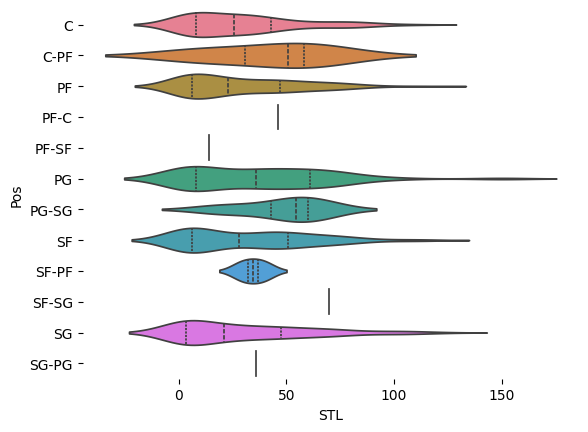

In [17]:
#visualizes the data
#x is the number of steals, y is the position
sns.violinplot(bb_data, x='STL', y='Pos', inner='quart',hue='Pos')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

The violin appears to be skewed right with PG's having by far the highest max, which looks like about 175. However, the highest median belongs to the PG-SG position with a median around 55, with C-PF's tailing with about 50 steals.

In [18]:
#identifies and stores all the different positions in our data set
pos_encode = pd.Categorical(bb_data['Pos'])
pos_encode

['PF-C', 'C', 'SG', 'PF', 'SG', ..., 'PF', 'PG', 'C', 'C', 'C']
Length: 572
Categories (12, object): ['C', 'C-PF', 'PF', 'PF-C', ..., 'SF-PF', 'SF-SG', 'SG', 'SG-PG']

In [19]:
#Replaces all the position names with a number in the variable pos_idx
pos_idx = pos_encode.codes
#stores the category names in a dictionary
pos_coords = {"Pos": pos_encode.categories}
pos_coords


{'Pos': Index(['C', 'C-PF', 'PF', 'PF-C', 'PF-SF', 'PG', 'PG-SG', 'SF', 'SF-PF',
        'SF-SG', 'SG', 'SG-PG'],
       dtype='object')}

I'll start with a normal hierarchal model. I know this won't work but I'm just curious as to what it'll produce.

In [22]:
with pm.Model(coords=pos_coords) as bb_h_model:
    # hyperpriors
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "Pos")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "Pos")

    #likelihood
    y = pm.Normal('y',
                  mu = μ[pos_idx],
                  sigma = σ[pos_idx],
                  observed = bb_data.STL)

    #bb for chemshift, h for hierarchical
    idata_bb_h = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='y'>

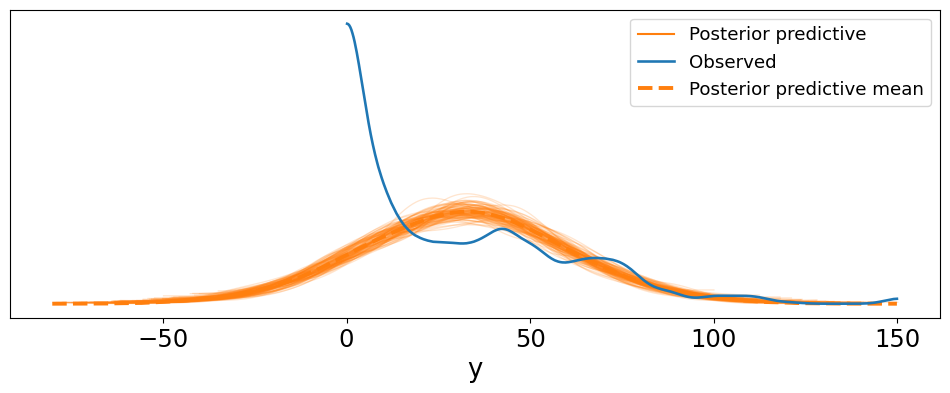

In [23]:
#visualize
pm.sample_posterior_predictive(idata_bb_h, model=bb_h_model, extend_inferencedata=True)
az.plot_ppc(idata_bb_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

As expected, it failed horribly. However, now I have a better idea on what model to use; I'll use exponential in the next one.

In [29]:
with pm.Model(coords = pos_coords) as bball_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b)

    #exponential likelihood
    _ = pm.Exponential('pos', lam = λ, observed = bb_data.STL)

    #a very high target acceptance to limit divergences
    idata_bball = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

<Axes: xlabel='pos'>

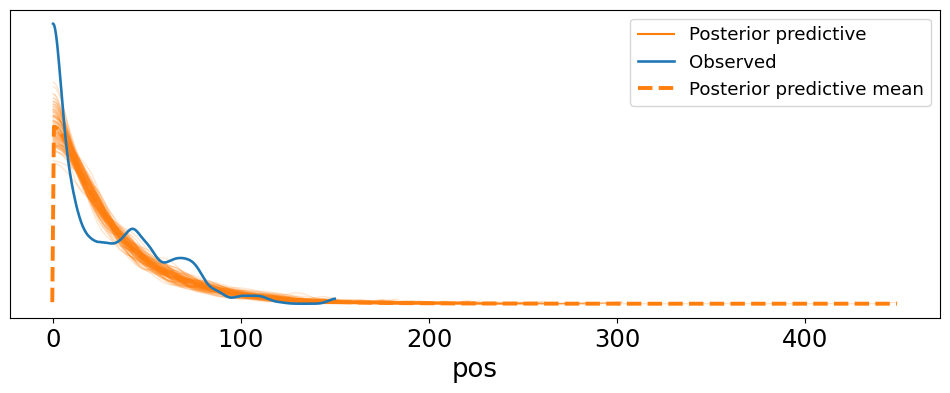

In [30]:
#visualize
pm.sample_posterior_predictive(idata_bball, model=bball_model, extend_inferencedata=True)
az.plot_ppc(idata_bball, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This looks about as good as I'll get because I can't incorporate those little bumps into my model. Now, I'll use this model to compare the steals to the position categories.

In [33]:
with pm.Model(coords = pos_coords) as bball_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = 'Pos')

    #exponential likelihood
    _ = pm.Exponential('pos', lam = λ[pos_idx], observed = bb_data.STL)

    #a very high target acceptance to limit divergences
    idata_bball = pm.sample(target_accept = 0.95)

Output()

Output()

<xarray.Dataset> Size: 352B
Dimensions:  (Pos: 12)
Coordinates:
  * Pos      (Pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 1.001
    b        float64 8B 1.001
    λ        (Pos) float64 96B 0.9997 0.9997 1.002 1.0 ... 1.001 1.001 1.001

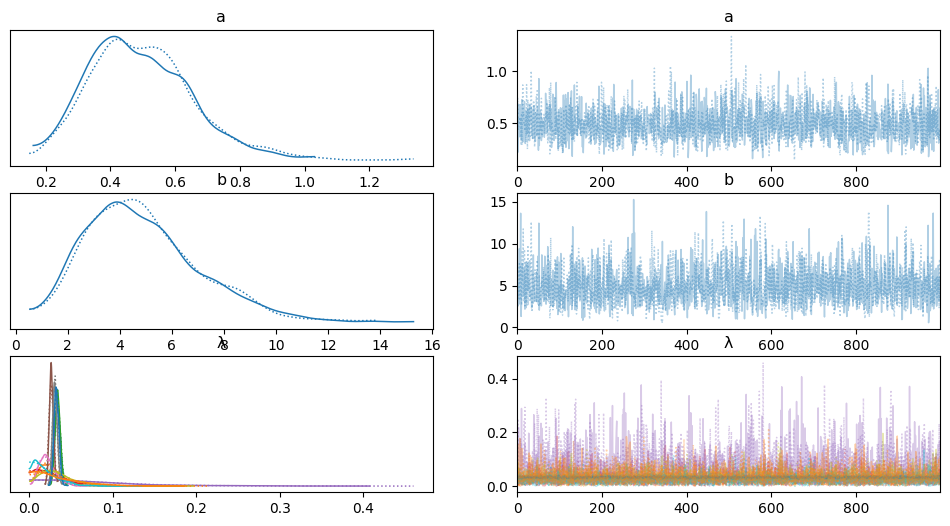

In [34]:
az.plot_trace(idata_bball)
az.rhat(idata_bball)

array([<Axes: >], dtype=object)

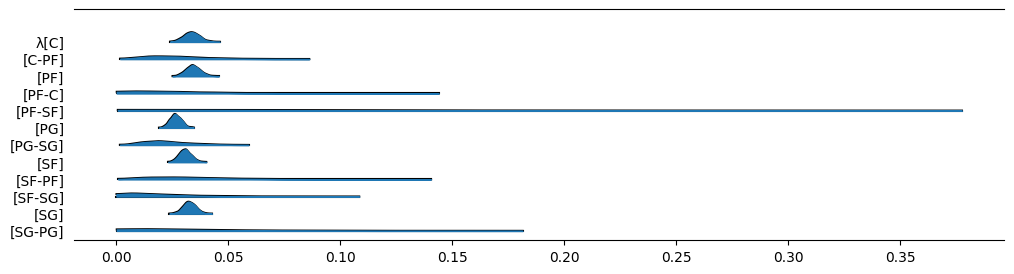

In [35]:
az.plot_forest(idata_bball, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

In [37]:
#reciprocals of estimated λ means
print(f'C: {1/.035}')
print(f'C-PF: {1/.022}')
print(f'PF: {1/.035}')
print(f'PF-SF: {1/.02}')
print(f'PG: {1/.025}')
print(f'PG-SG: {1/.017}')
print(f'SF: {1/.032}')
print(f'SF-PF: {1/.022}')
print(f'SF-SG: {1/.011}')
print(f'SG: {1/.033}')

C: 28.57142857142857
C-PF: 40.0
PF: 28.57142857142857
PF-SF: 50.0
PG: 40.0
PG-SG: 58.8235294117647
SF: 31.25
SF-PF: 45.45454545454546
SF-SG: 90.90909090909092
SG: 30.3030303030303


**Conclusion**

These results actually surprised me. Initially, I expected guards to be getting the most steals but it turned out that centers and small forwards were getting most (as you can see their estimated mean λ reciprocals were the lowest at 28.57. I guess this makes sense because players dribbling into the paint tend to turn the ball over more than players dribbling on the perimeter. The fact that centers play in the paint means that they would be stealing the ball from the players dribbling in.

I think this data has some slight issues in the way it reports positions. The fact that players can play multiple positions forces new categories to be created and I feel like those categories may be innacurate. Especially the SF-SG category, which had a super high reciprocal compared to every other category. If I had more time to work on this project, I would want to come up with a way to combine those into the other positions categories.